In [14]:
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd

%matplotlib inline

In [3]:
df = pd.read_csv('../data/fr.openfoodfacts.org.products.csv', sep='\t')

/tmp/ipykernel_16772/3243065608.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/fr.openfoodfacts.org.products.csv', sep='\t')


In [4]:
df.shape

(320772, 162)

In [5]:
df = df.dropna(how='all', axis=1)

In [6]:
df.shape

(320772, 146)

In [11]:
df.iloc[:,:54].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 54 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   code                                        320749 non-null  object 
 1   url                                         320749 non-null  object 
 2   creator                                     320770 non-null  object 
 3   created_t                                   320769 non-null  object 
 4   created_datetime                            320763 non-null  object 
 5   last_modified_t                             320772 non-null  object 
 6   last_modified_datetime                      320772 non-null  object 
 7   product_name                                303010 non-null  object 
 8   generic_name                                52795 non-null   object 
 9   quantity                                    104819 non-null  object 
 

In [7]:
df.sample(10)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
284015,6627704470805,http://world-fr.openfoodfacts.org/produit/6627...,openfoodfacts-contributors,1428607297,2015-04-09T19:21:37Z,1428607300,2015-04-09T19:21:40Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119432,628055012047,http://world-fr.openfoodfacts.org/produit/0628...,usda-ndb-import,1489091204,2017-03-09T20:26:44Z,1489091204,2017-03-09T20:26:44Z,Caramel Apples With Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0
297863,7617400037920,http://world-fr.openfoodfacts.org/produit/7617...,openfood-ch-import,1486505524,2017-02-07T22:12:04Z,1487256948,2017-02-16T14:55:48Z,Gaufrettes CITRON,NaN,235 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,15.0
69805,70253288678,http://world-fr.openfoodfacts.org/produit/0070...,usda-ndb-import,1489070324,2017-03-09T14:38:44Z,1489070324,2017-03-09T14:38:44Z,Soda Cola,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284402,6923744329012,http://world-fr.openfoodfacts.org/produit/6923...,jacob80,1430393645,2015-04-30T11:34:05Z,1430397799,2015-04-30T12:43:19Z,"Nouilles instantanées, Arôme poulet teriyaki (...",Préparation alimentaire à base de blé tendre e...,85 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
63998,52100071466,http://world-fr.openfoodfacts.org/produit/0052...,usda-ndb-import,1489067342,2017-03-09T13:49:02Z,1489067342,2017-03-09T13:49:02Z,"Minced Garlic, California Style",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34835,37600280723,http://world-fr.openfoodfacts.org/produit/0037...,usda-ndb-import,1489056208,2017-03-09T10:43:28Z,1489056209,2017-03-09T10:43:29Z,"Dinty Moore, Meatball Stew",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0
77752,71986120617,http://world-fr.openfoodfacts.org/produit/0071...,usda-ndb-import,1489051936,2017-03-09T09:32:16Z,1489051937,2017-03-09T09:32:17Z,Puffed Red Wheat Cereal,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.0,-6.0
49917,41497331260,http://world-fr.openfoodfacts.org/produit/0041...,usda-ndb-import,1489051802,2017-03-09T09:30:02Z,1489051802,2017-03-09T09:30:02Z,Chunky Chicken Noodle Soup,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
310103,8436029252007,http://world-fr.openfoodfacts.org/produit/8436...,granavida,1429519703,2015-04-20T08:48:23Z,1429520443,2015-04-20T09:00:43Z,Zumo de granada Granavida,zumo de granada elaborado con granadas mollar...,200 ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0


In [12]:
df_gen = df.iloc[:, :10]
df_tags = df.iloc[:, 10:34]
df_ingredients = df.iloc[:, 34:40]
df_misc = df.iloc[:, 40:54]
df_nutrition = df.iloc[:, 54:]

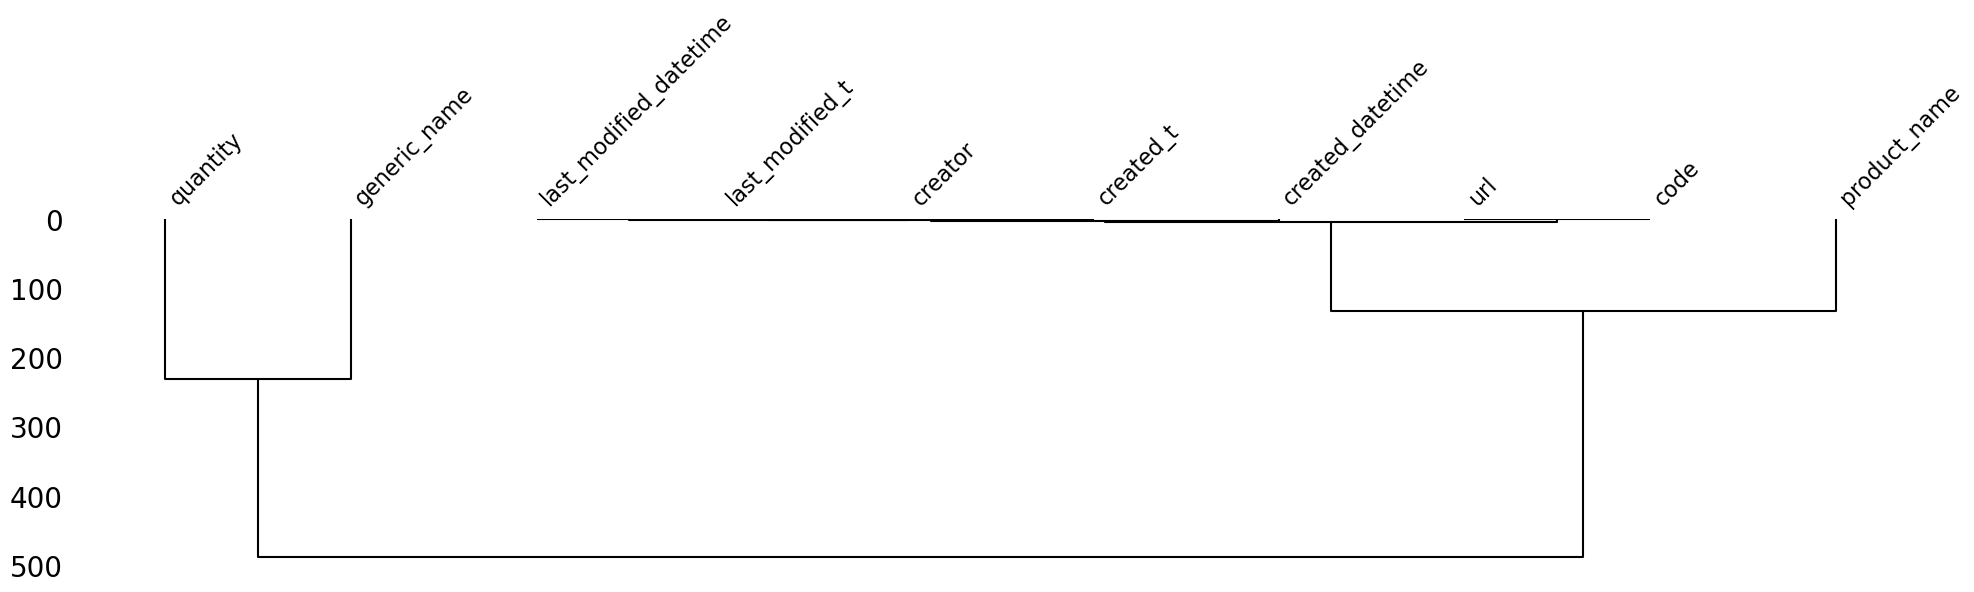

In [16]:
msno.dendrogram(df_gen, figsize=(20, 6))
plt.tight_layout()
plt.show()

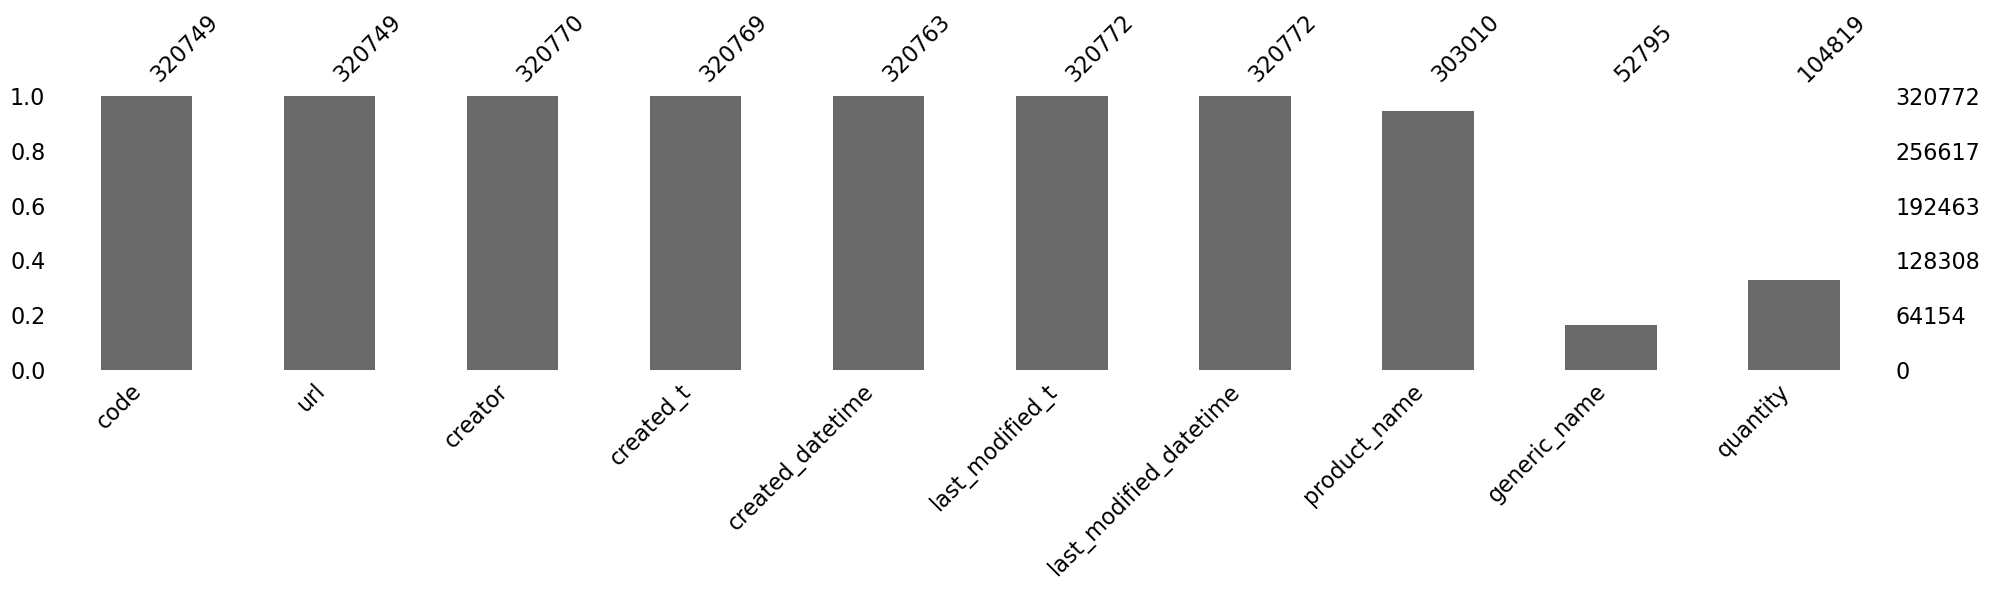

In [17]:
msno.bar(df_gen, figsize=(20, 6))
plt.tight_layout()
plt.show()

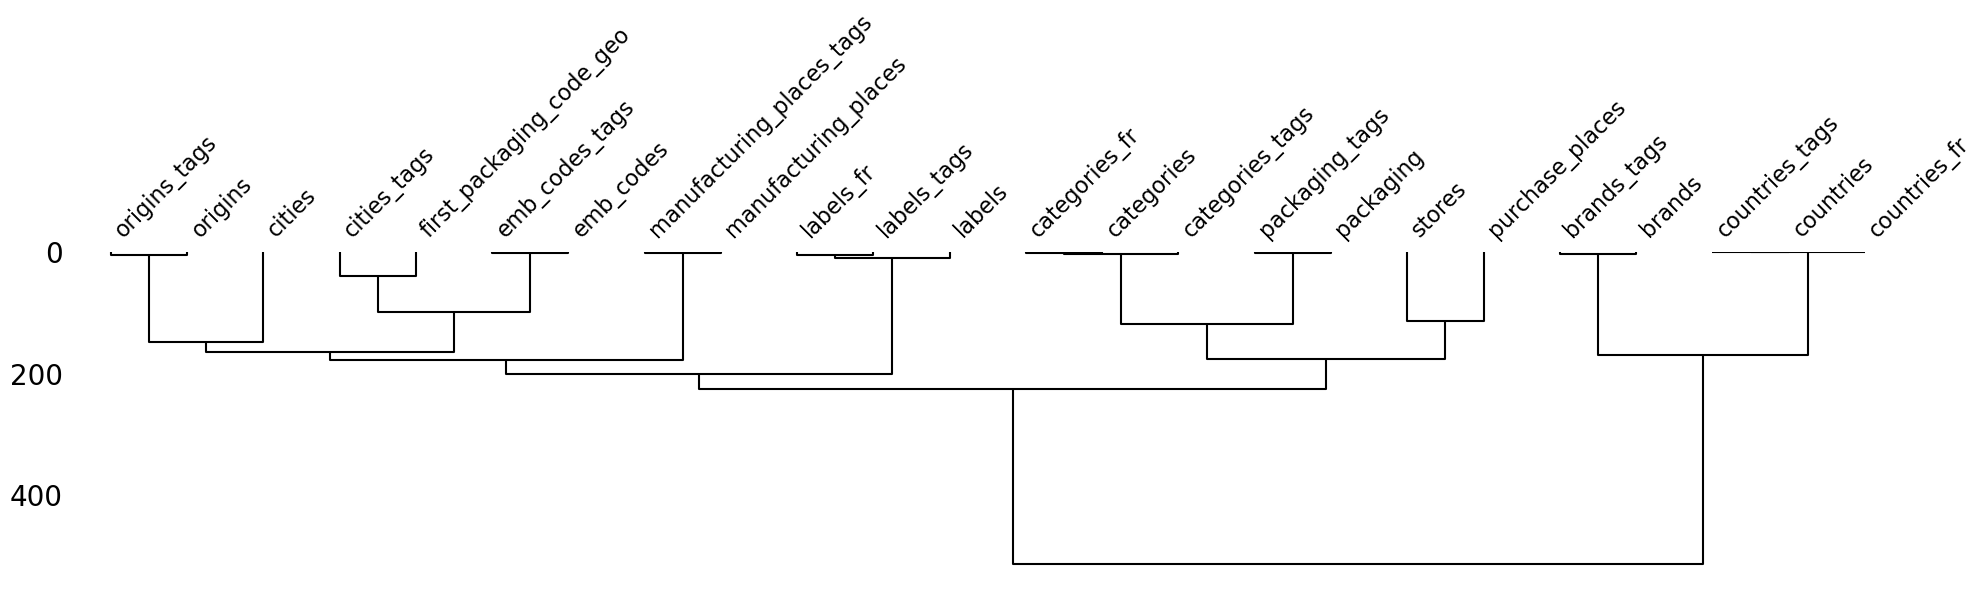

In [18]:
msno.dendrogram(df_tags, figsize=(20, 6))
plt.tight_layout()
plt.show()

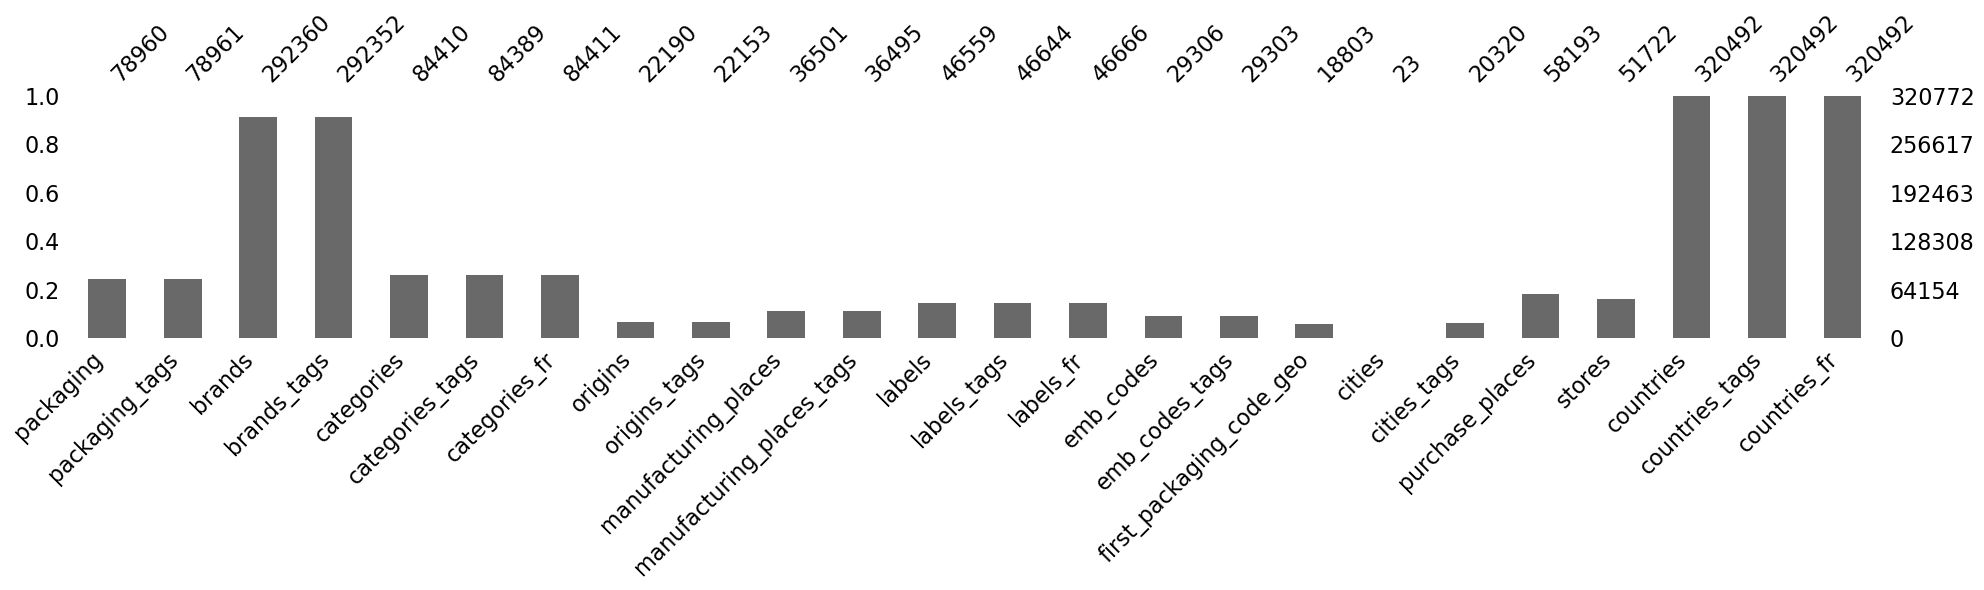

In [20]:
msno.bar(df_tags, figsize=(20, 6))
plt.tight_layout()
plt.show()

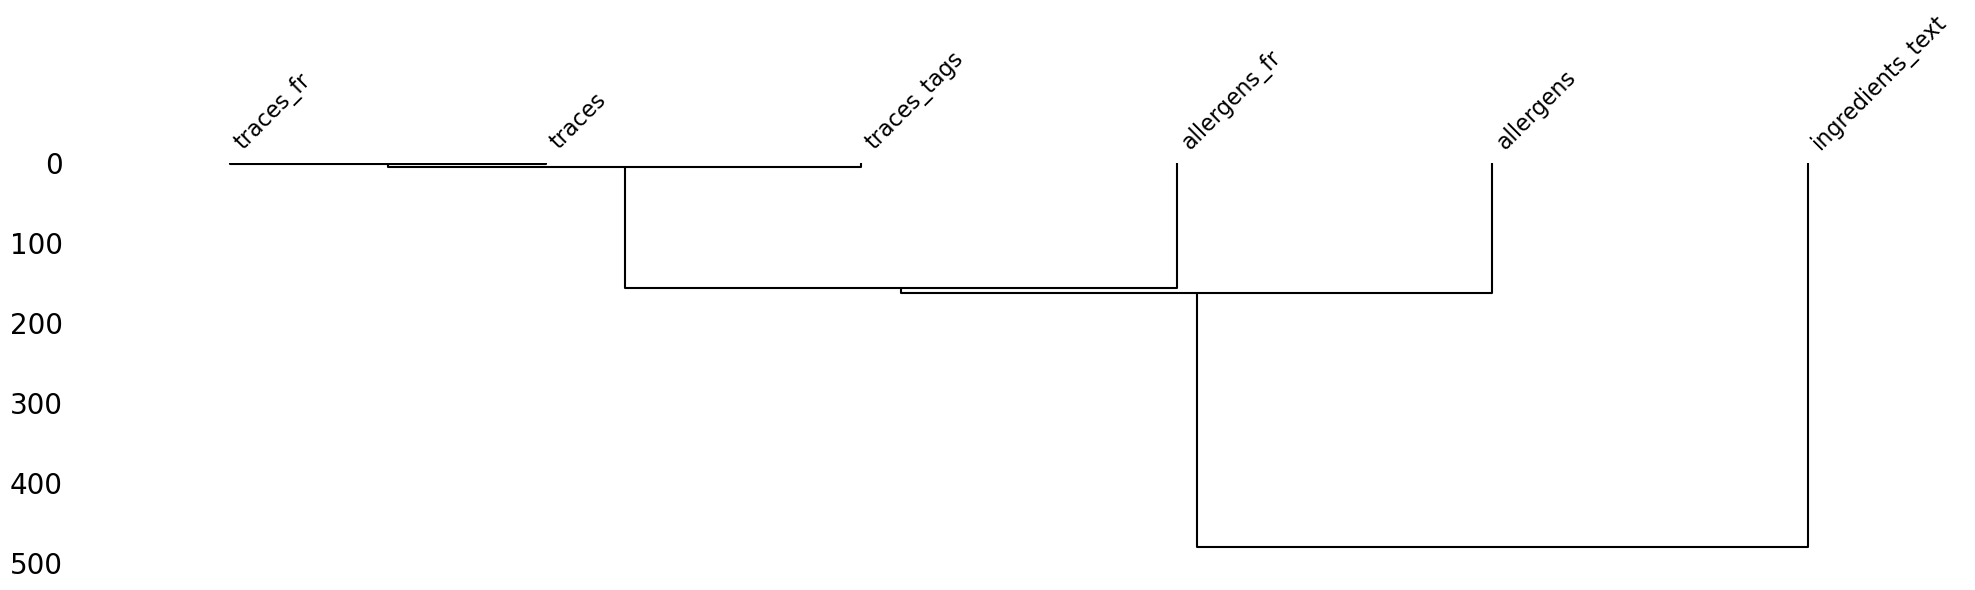

In [21]:
msno.dendrogram(df_ingredients, figsize=(20, 6))
plt.tight_layout()
plt.show()

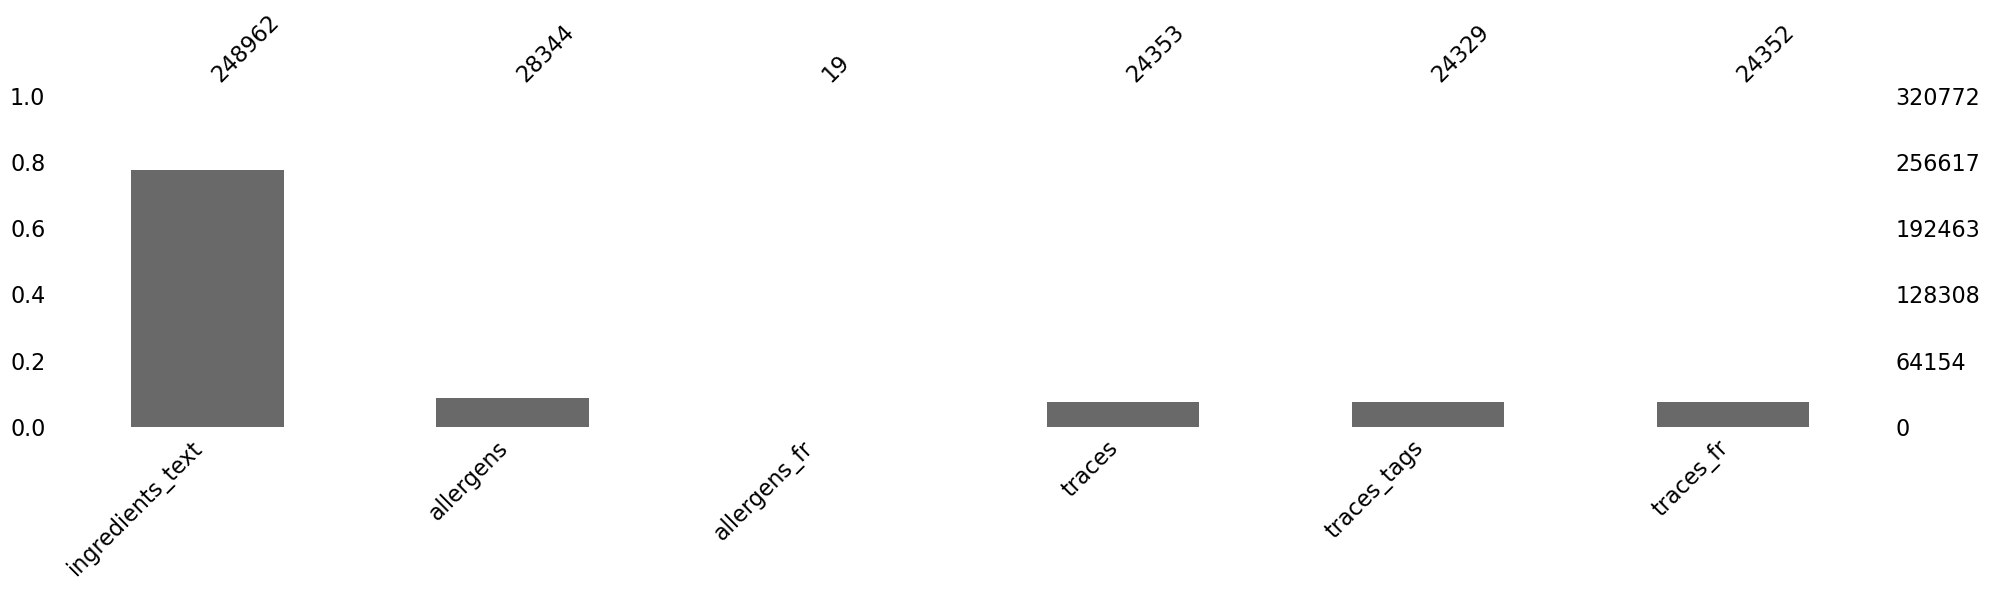

In [23]:
msno.bar(df_ingredients, figsize=(20, 6))
plt.tight_layout()
plt.show()

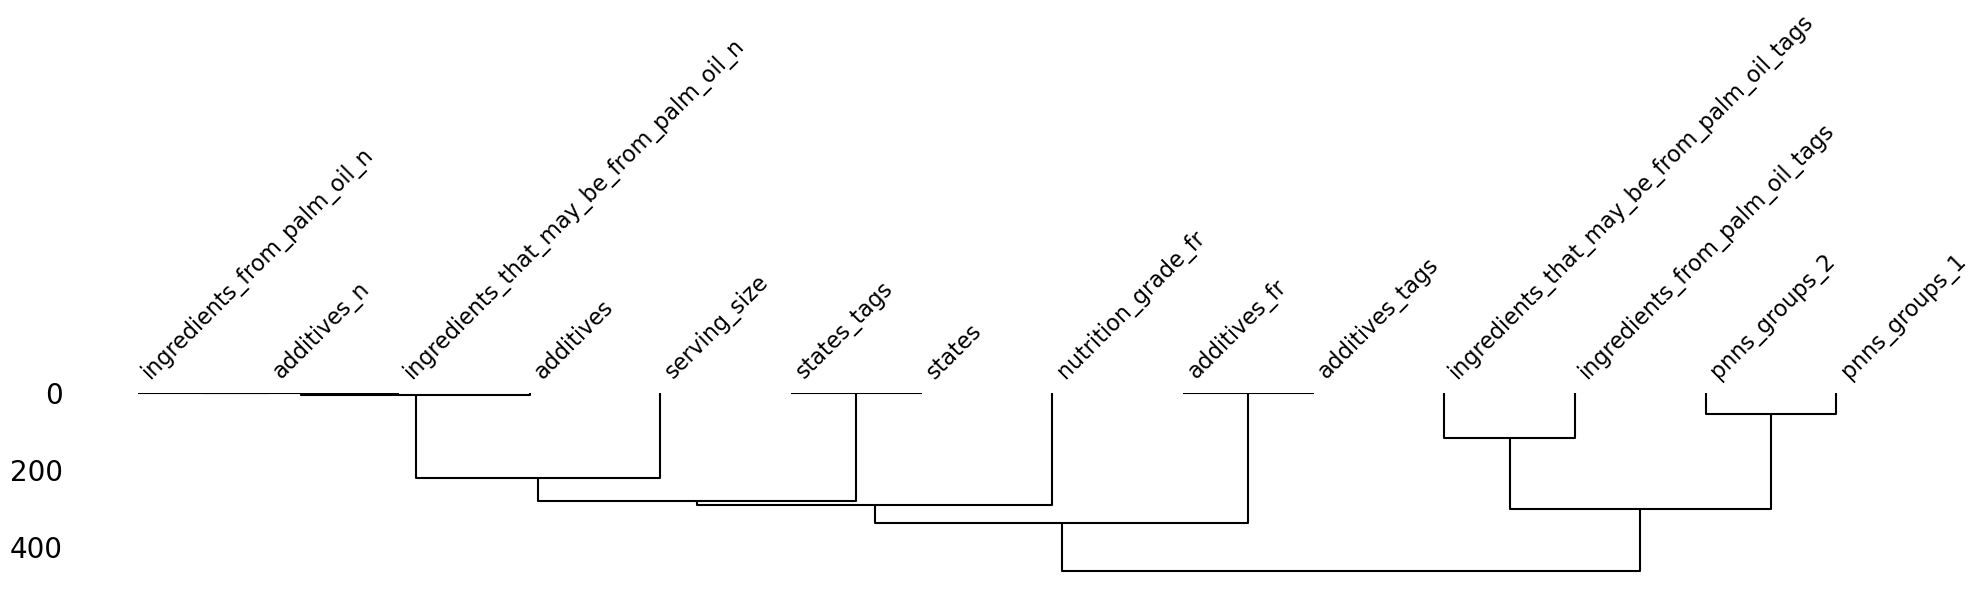

In [24]:
msno.dendrogram(df_misc, figsize=(20, 6))
plt.tight_layout()
plt.show()

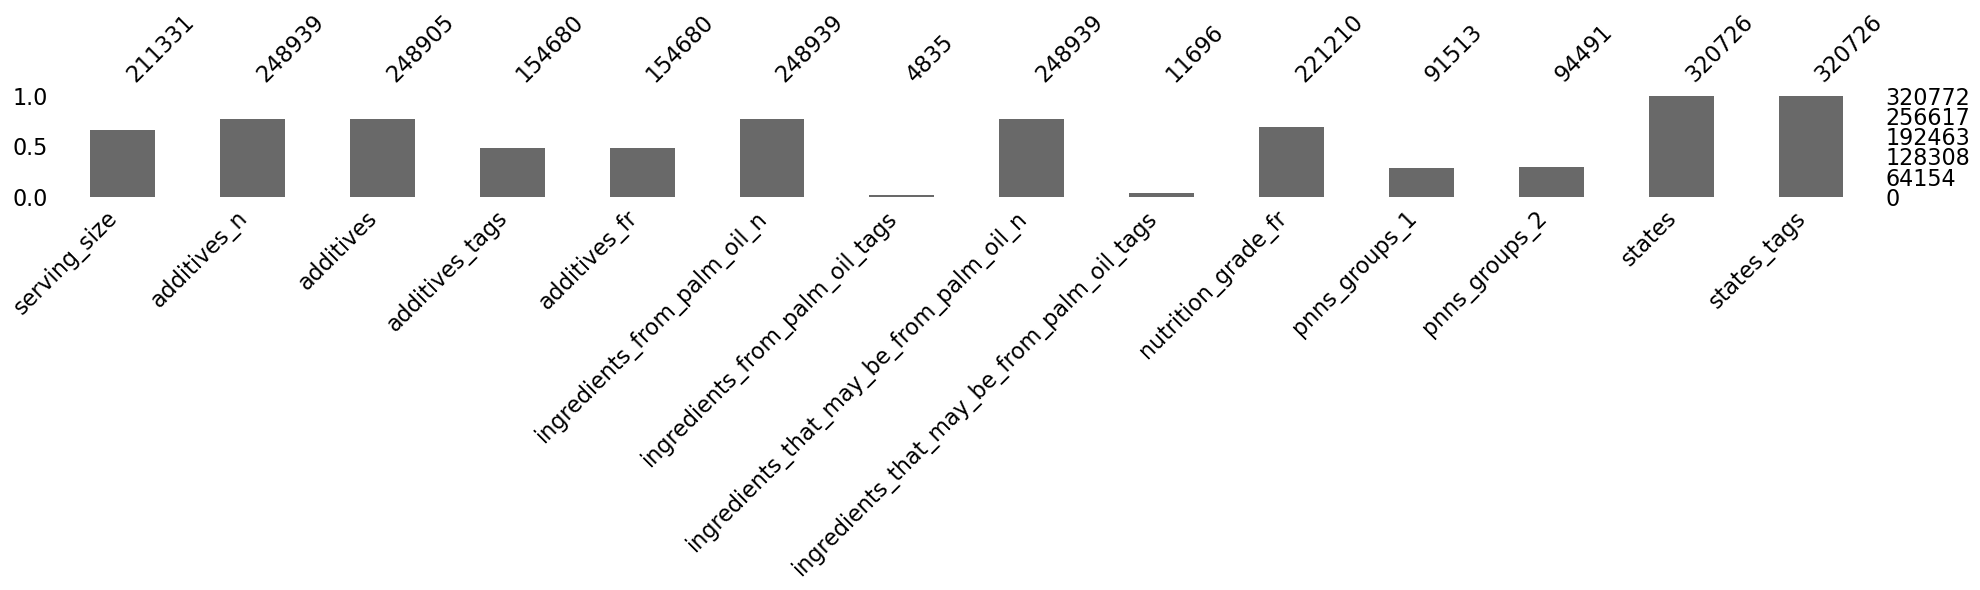

In [27]:
msno.bar(df_misc, figsize=(20, 6))
plt.tight_layout()
plt.show()

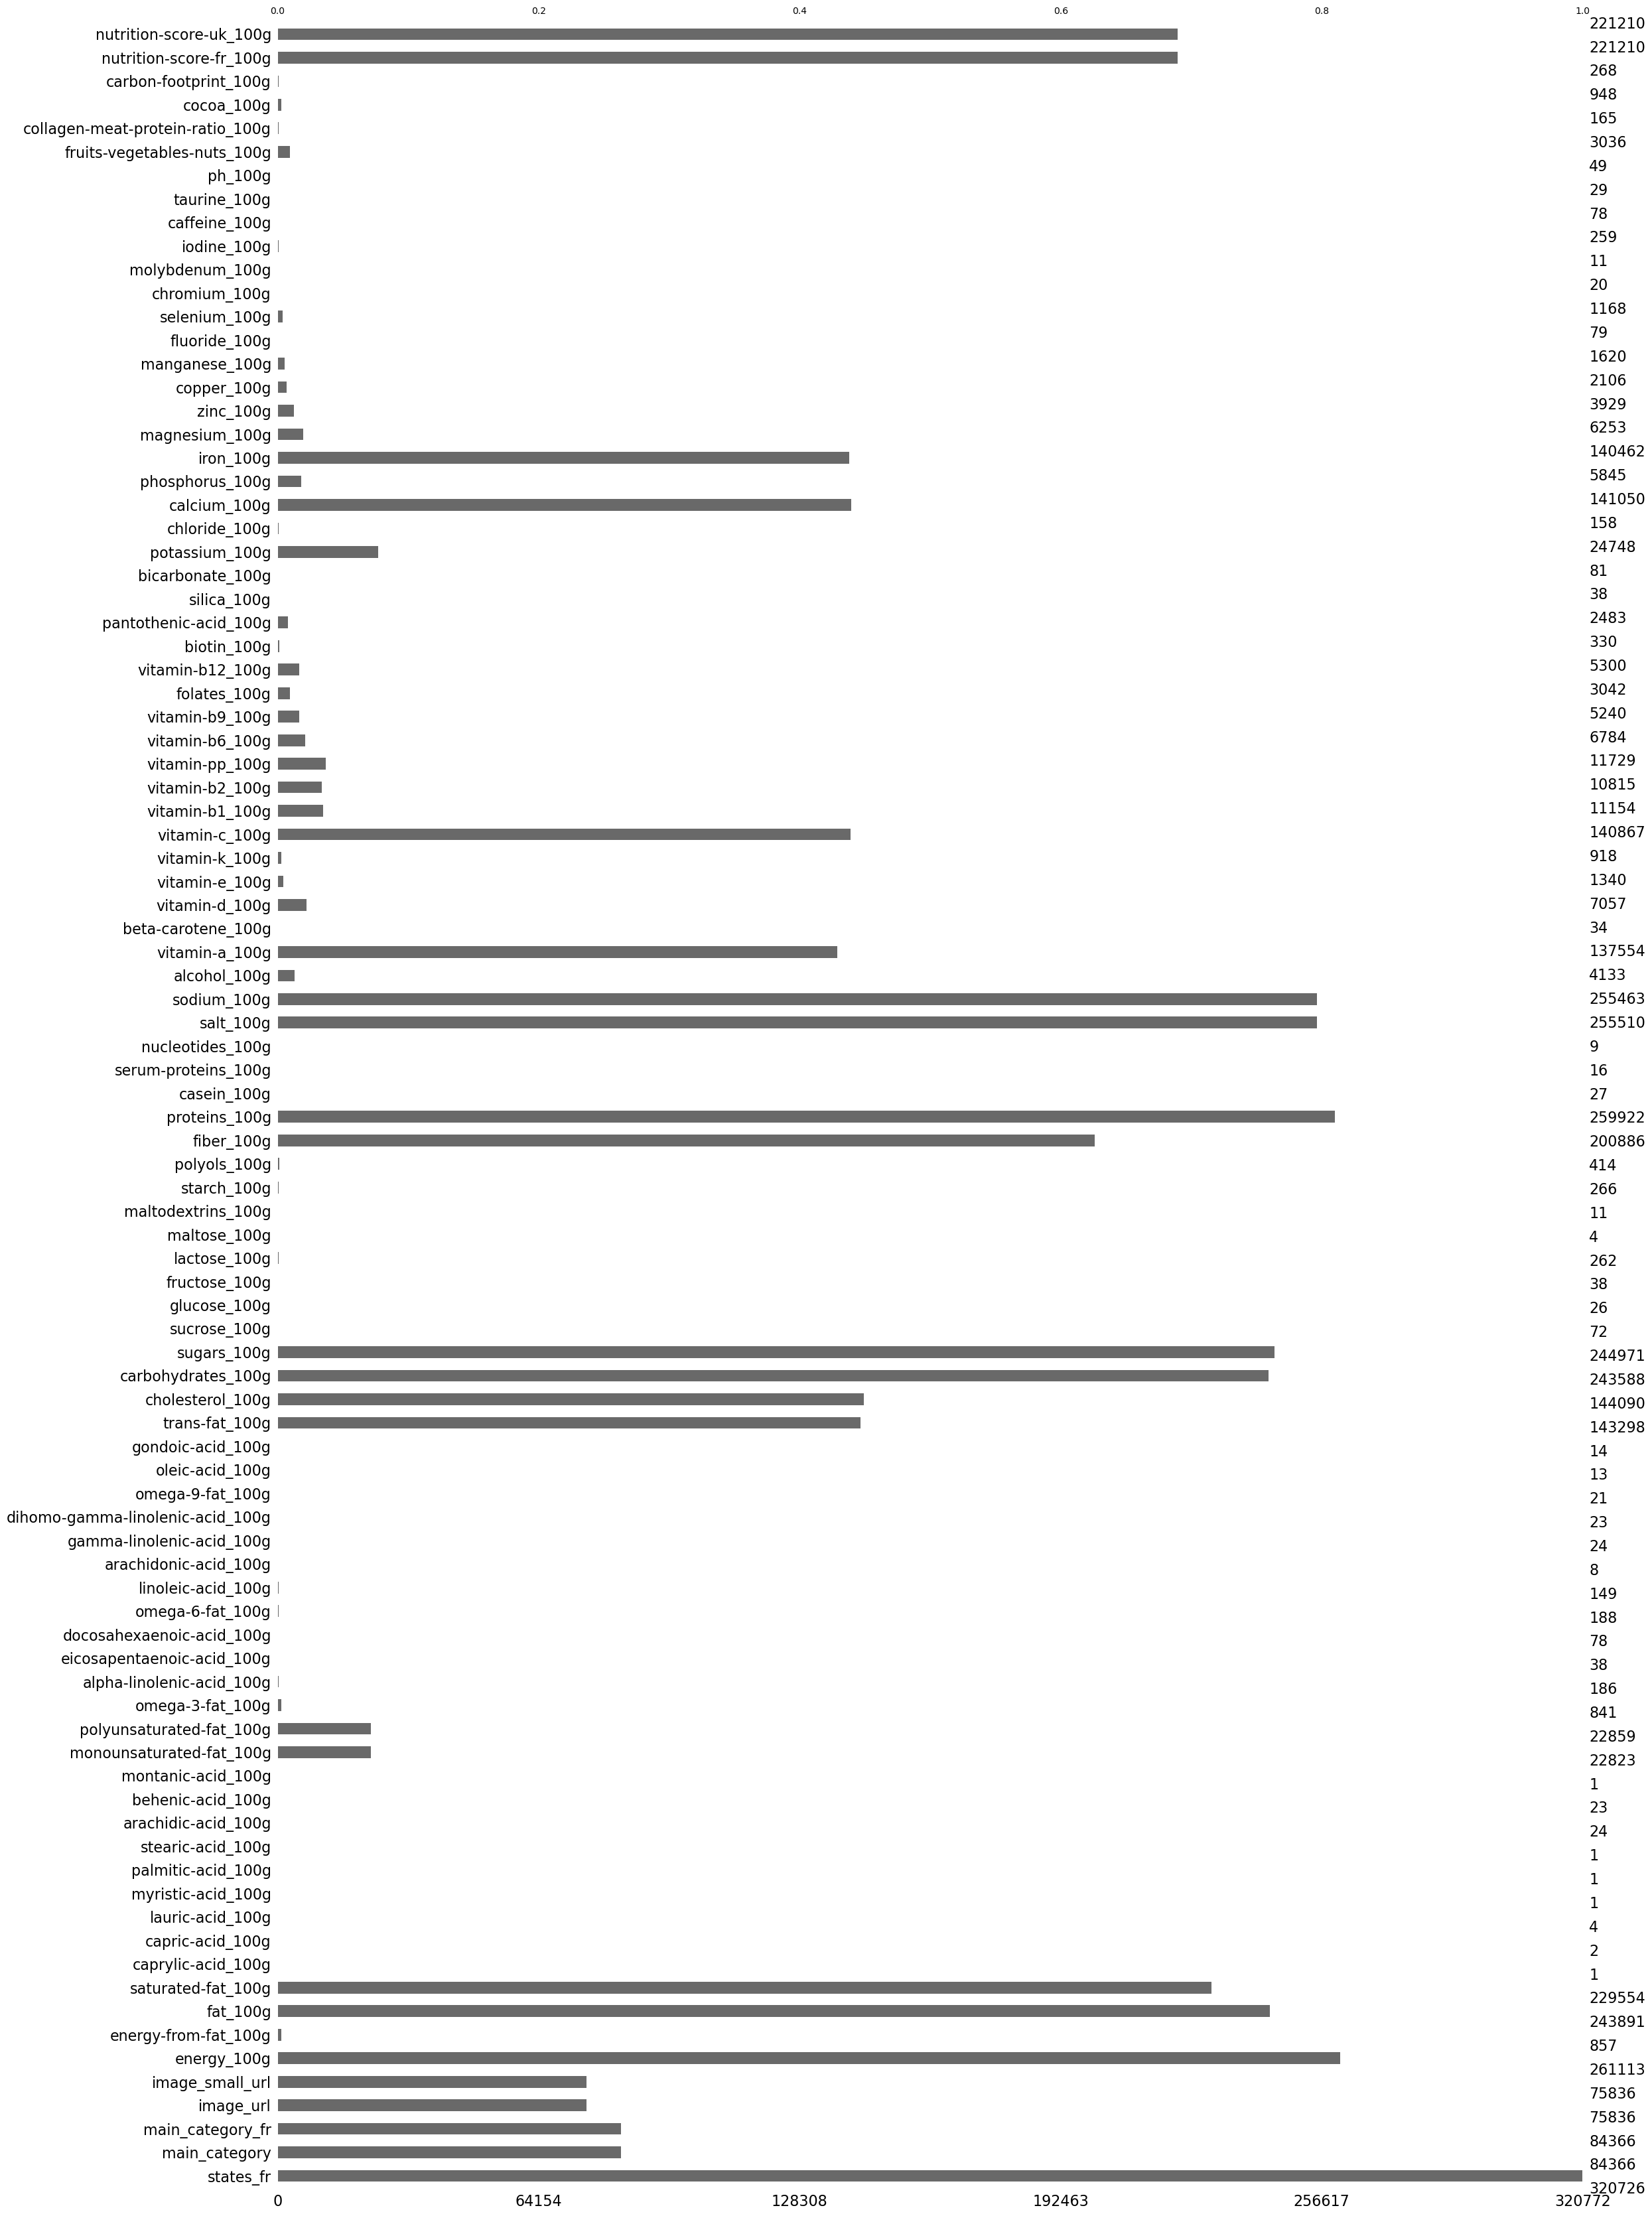

In [29]:
msno.bar(df_nutrition)
plt.tight_layout()
plt.show()